In [1]:
library(dplyr) # for data manipulation
library(tidytext) # for text mining
library(tidyverse) # for text mining
library(gridExtra) # for plotting
library(tm) # for text mining
#library(gbm) # for boosting tree models
#library(cvTools) # for cross validation
#library(textstem) # for lemmatization
library(caret) # for confusion matrix
#library(e1071) # for SVM models
library(Matrix)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1     v readr   1.3.1
v tibble  2.1.1     v purrr   0.3.2
v tidyr   0.8.3     v stringr 1.4.0
v ggplot2 3.1.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Loading required package: NLP

Attaching package: 'NLP'

The following object is mas

# 1. Exploratory Data Analysis

In [2]:
# load in training data
train_data <- read.csv(file="./train_data.csv", header=TRUE, sep=",", stringsAsFactors = FALSE)
# load in training label
train_label <- read.csv(file="./train_label.csv", header=TRUE, sep=",")
# we first merge both training data and it's label together
train_data_merge <- merge(x = train_data, y = train_label, by = "trn_id", all = TRUE, sort = FALSE)

# count number of na values
cat("\nNumber of reviews with na value:",sum(is.na(train_data_merge)))
# count number of duplicated data based on their text and label
cat("\nNumber of duplicated reviews with similar labels:",nrow(train_data_merge[duplicated(train_data_merge[,c('text','label')]),]))
# count number of duplicated data based on their text with different labels
cat("\nNumber of duplicated reviews with different labels:",nrow(train_data_merge[duplicated(train_data_merge[,'text']),]))

# remove duplicated data
train_data_merge <- train_data_merge[!duplicated(train_data_merge[,c('text','label')]),]
# remove duplicated text with different labels
train_data_merge <- train_data_merge[!duplicated(train_data_merge[,'text']),]
# count number of unique reviews after remove of duplications
cat("\nNumber of unique reviews:",nrow(train_data_merge))

# convert table to tibble format
train_data_merge <- tibble(doc=1:nrow(train_data_merge),text=train_data_merge$text,label=train_data_merge$label)


Number of reviews with na value: 0
Number of duplicated reviews with similar labels: 827
Number of duplicated reviews with different labels: 950
Number of unique reviews: 649050

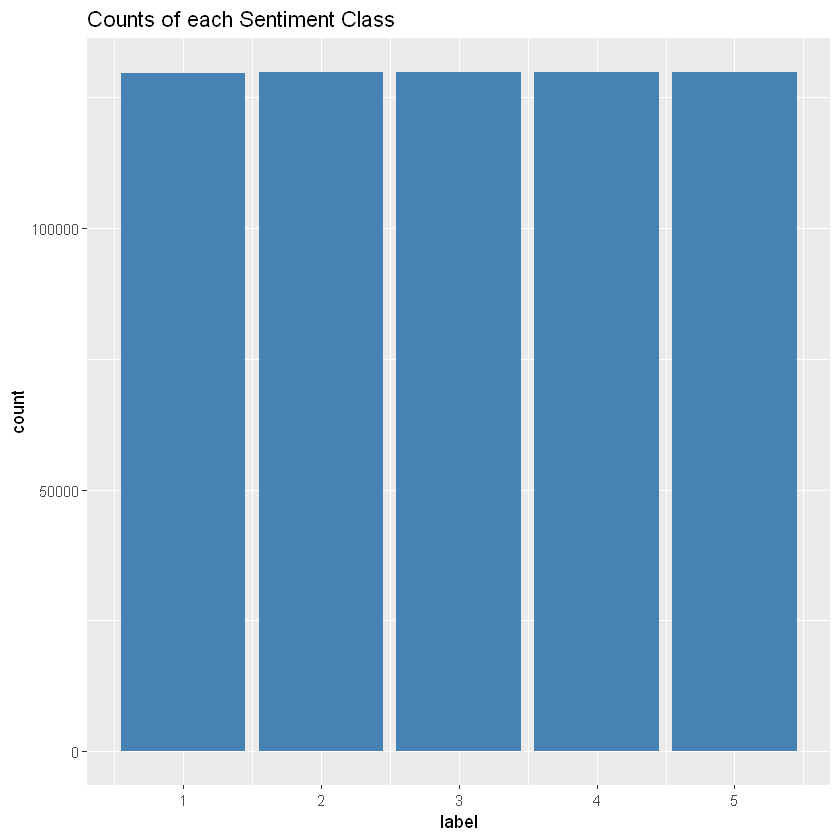

In [3]:
# turn off scientific display in plot
options(scipen = 999) 
# plot counts of each sentiment class in this dataset
ggplot(train_data_merge, aes(label)) +
  geom_bar(fill = "steelblue")  +
  ggtitle("Counts of each Sentiment Class")

In [4]:
# get total number of reviews across each sentiment class
train_data_merge %>% group_by(label) %>% 
    summarise(count = n_distinct(doc))

label,count
1,129717
2,129827
3,129829
4,129834
5,129843


As the training dataset is large, we consider just 300000 training samples to train our model. Note that we will need to ensure the proportion of labels of each sentiment class is balanced in our training dataset. Also, we will extract another 50000 training samples from the remaining unsampled training data as our testing data.

In [5]:
#set.seed(1234)
#validation_index <- sample(1:649050, .1*649050, replace = FALSE)

In [3]:
# set seed to ensure consistent samples
set.seed(123)
# filter to the classes
class1 <- train_data_merge[train_data_merge$label==1,]
class2 <- train_data_merge[train_data_merge$label==2,]
class3 <- train_data_merge[train_data_merge$label==3,]
class4 <- train_data_merge[train_data_merge$label==4,]
class5 <- train_data_merge[train_data_merge$label==5,]

# sample 300000 records from each classes as training sample
sample1 <- class1[sample(nrow(class1), 40000),]
sample2 <- class2[sample(nrow(class2), 40000),]
sample3 <- class3[sample(nrow(class3), 40000),]
sample4 <- class4[sample(nrow(class4), 40000),]
sample5 <- class5[sample(nrow(class5), 40000),]

# combine all sample to form train_data
train_data <- rbind(sample1, sample2, sample3, sample4, sample5)

# sample 50000 records from remaining unsampled training data as testing data
#test_data <- anti_join(train_data_merge, train_data, by='doc')
#test_data <- test_data[sample(nrow(test_data), 50000),]

In [6]:
ls()

[1] "train_data"

In [ ]:
rm(class1, class2, class3, class4, class5, sample1, sample2, sample3, sample4, sample5, train_data_merge, train_label)

# 2. Text Preprocessing

## 2.1 Tokenization & Case Normalization
We first tokenize our training data in which each word is being stored as one token. We can make use of `unnest_tokens` function from `tidytext` but by default, it will remove all punctuations. We disable this default function first as we are interested to identify if presence of punctuations affect their sentiment class. We will also convert the tokens to all lower cases.

In [8]:
# using unnest_tokens in tidytext library
tokens <- train_data %>% unnest_tokens(word, text, strip_punct = FALSE)

In [9]:
# Initial status of corpus
# total number of reviews
tokens %>% summarise(docs_total = n_distinct(doc))
# total number of tokens
tokens %>% summarise(tokens_total = n())
# vocabulary size (number of unique tokens)
tokens %>% summarise(vocab_size = n_distinct(word))
# lexical diversity (average number of tokens per review)
tokens %>% summarise(lex_div = n()/n_distinct(doc))
# min length of review
tokens %>% group_by(doc) %>% summarise(length = sum(n())) %>% summarise(min_length=min(length))
# max length of review
tokens %>% group_by(doc) %>% summarise(length = sum(n())) %>% summarise(max_length=max(length))

docs_total
200000


tokens_total
28262800


vocab_size
123770


lex_div
141.314


min_length
1


max_length
10099


Initial corpus status:
- Total no. of reviews: 300000
- Total no. of tokens: 42470317
- Total vocabulary size: 151776
- Lexical Diversity: 141.5677
- Smallest Document Size: 1
- Largest Document Size: 10142

## 2.2 Remove Punctuations

Punctuations are normally removed in text mining process because they serve little meaning and purpose.

However, as we are dealing with a dataset relating to product reviews, logically speaking, usage of punctuation  like `!` in product reviews will represent reviews that are highly positive <i>("This product is what I need!")</i> or highly negative <i>("I don't like this product!")</i>. Similarly, usage of `?` in a product review may indicate a negative sentiment <i>("Why is the service so bad?")</i>. As a result, it would be worthwhile to explore if that's the case in this dataset, whether we will be able to identify any relationship between usage of `!` or `?` in product reviews against their given sentiment rating.

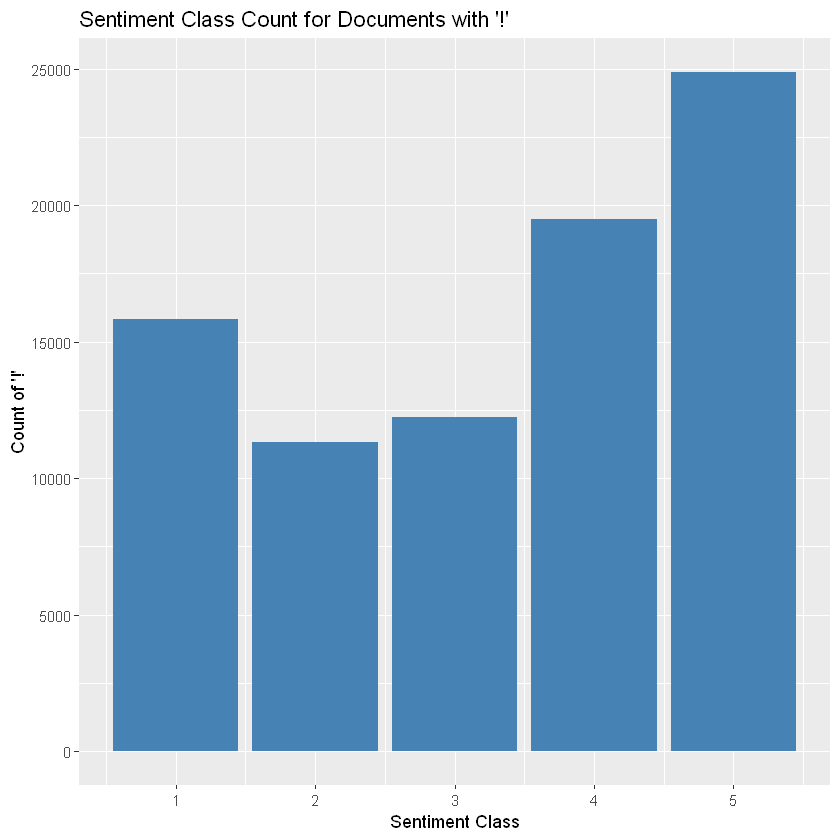

In [9]:
# get count of '!' appearing in each document across each sentiment class and plot the result
tokens %>% filter(word=='!') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("Sentiment Class Count for Documents with '!'") + labs(x = 'Sentiment Class', y = "Count of '!'")

The plot seems to suggest that having `!` in the product review indicated weak and strong positive (i.e. class 4 and 5). As a result, we should not remove them from our vocabulary.

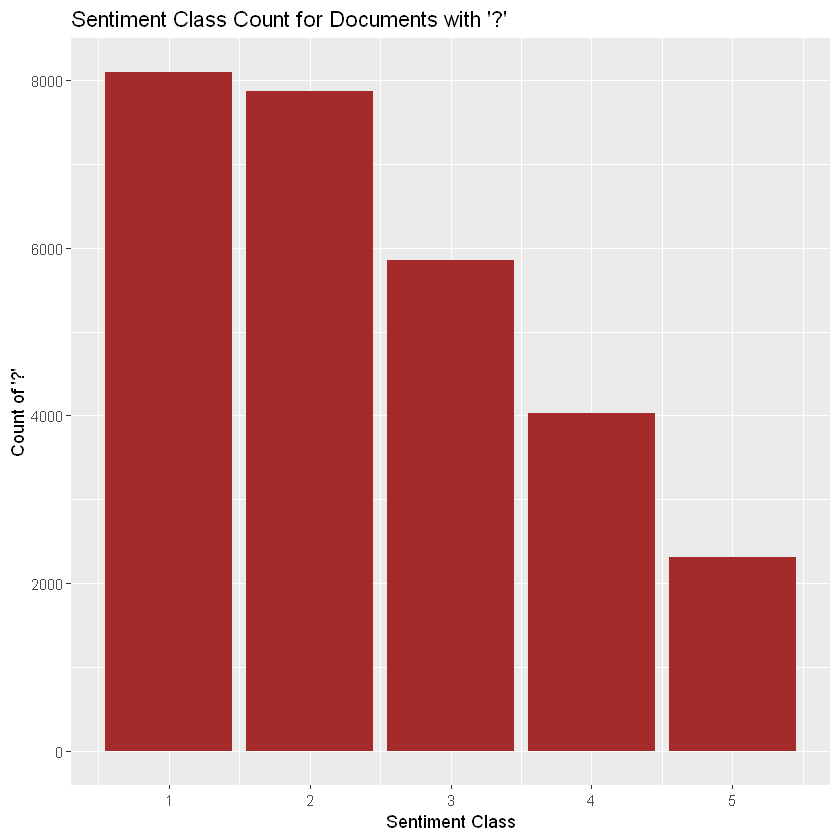

In [10]:
# get count of '?' appearing in each document across each sentiment class and plot the result
tokens %>% filter(word=='?') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='brown')  +
    ggtitle("Sentiment Class Count for Documents with '?'") + labs(x = 'Sentiment Class', y = "Count of '?'")

The plot clearly shows our guess that `?` is associated with negative reviews is right as there are high numbers belonging to strong negative and weak negative (i.e. Class 1 and Class 2), hence, we will also keep `?` in our vocabulary and not discard them.

Therefore, we will remove all punctuations other than `!` and `?` from our corpus.

In [11]:
# unnest tokens again to remove all punctuations
temp_tokens <- train_data %>% unnest_tokens(word, text, strip_punct = TRUE)
# add in the tokens with '!' and '?'
tokens <- temp_tokens %>% bind_rows(tokens %>% filter(word=='!' | word=='?'))

rm(temp_tokens)

In [12]:
# Status of corpus
# total number of reviews
tokens %>% summarise(docs_total = n_distinct(doc))
# total number of tokens
tokens %>% summarise(tokens_total = n())
# vocabulary size (number of unique tokens)
tokens %>% summarise(vocab_size = n_distinct(word))
# lexical diversity (average number of tokens per review)
tokens %>% summarise(lex_div = n()/n_distinct(doc))
# min length of review
tokens %>% group_by(doc) %>% summarise(length = sum(n())) %>% summarise(min_length=min(length))
# max length of review
tokens %>% group_by(doc) %>% summarise(length = sum(n())) %>% summarise(max_length=max(length))

docs_total
<int>
200000


tokens_total
<int>
25019385


vocab_size
<int>
123895


lex_div
<dbl>
125.0969


min_length
<dbl>
1


max_length
<dbl>
2787


Corpus status after removal of punctuations:
- Total no. of reviews: 299999
- Total no. of tokens: 37520372
- Total vocabulary size: 151698
- Lexical Diversity: 125.0683
- Smallest Document Size: 1
- Largest Document Size: 5094

## 2.3 Removal of Special Characters

In [22]:
head(tokens%>%filter(word=='ã'))

doc,label,word
<int>,<int>,<chr>
380258,1,ã
443666,1,ã
184500,1,ã
184500,1,ã
642494,1,ã
163824,1,ã


In [23]:
# remove special char
removespecialchar <- function(x) gsub("[^a-zA-Z0-9'!?]", " ", x)
tokens$word <- as.character(unlist(lapply(tokens$word, removespecialchar)))

In [24]:
# Status of corpus
# total number of reviews
tokens %>% summarise(docs_total = n_distinct(doc))
# total number of tokens
tokens %>% summarise(tokens_total = n())
# vocabulary size (number of unique tokens)
tokens %>% summarise(vocab_size = n_distinct(word))
# lexical diversity (average number of tokens per review)
tokens %>% summarise(lex_div = n()/n_distinct(doc))
# min length of review
tokens %>% group_by(doc) %>% summarise(length = sum(n())) %>% summarise(min_length=min(length))
# max length of review
tokens %>% group_by(doc) %>% summarise(length = sum(n())) %>% summarise(max_length=max(length))

docs_total
<int>
200000


tokens_total
<int>
25019385


vocab_size
<int>
123721


lex_div
<dbl>
125.0969


min_length
<dbl>
1


max_length
<dbl>
2787


## 2.4 Stopwords Removal

Next, we will remove stopwords which are extremely common and carry little lexical content. The list of stopwords can be found in the `tidytext` package using `stop_words` function. We will just use the stopwords from one lexicon `onix`.

Looking at the list of stopwords from the `onix` lexicon which can be found <a href="http://www.lextek.com/manuals/onix/stopwords1.html">here</a>, there are words that might be influential in determining the sentiment rating for the review especially if these words suggest possible negative or positive sentiments. One way we can identify stopwords that are positive or negative is through `sentiment` in the `tidytext` package, in particular, the `bing` lexicon.

We will explore the sentiments of `onix` stopwords using `bing` sentiment.

In [25]:
# filter sentiments to bing lexicon
bing_sentiments <- sentiments %>%
      filter(lexicon == "bing") %>%
      select(word, sentiment)

# filter stopwords to onix lexicon
stopwords <- stop_words %>% filter(lexicon == 'onix') 

# explore the sentiments of onix stopwords
onix_sentiments <- stopwords %>% inner_join(bing_sentiments, by = "word")

onix_sentiments

word,lexicon,sentiment
<chr>,<chr>,<chr>
best,onix,positive
better,onix,positive
clear,onix,positive
clearly,onix,positive
enough,onix,positive
evenly,onix,positive
good,onix,positive
great,onix,positive
greatest,onix,positive


Out of 429 stopwords in `onix` lexicon, there is a total of 20 stopwords which carry positive and negative sentiments. We will explore these words further to see if they are really indeed indicative of the sentiments in this dataset.

We can also look through the stopwords list and identify any potential stopwords that might be indicative in product reviews. In particular, we have decided to look at the following:
- against
- cannot
- high
- highest
- not
- no
- but
- never
- however

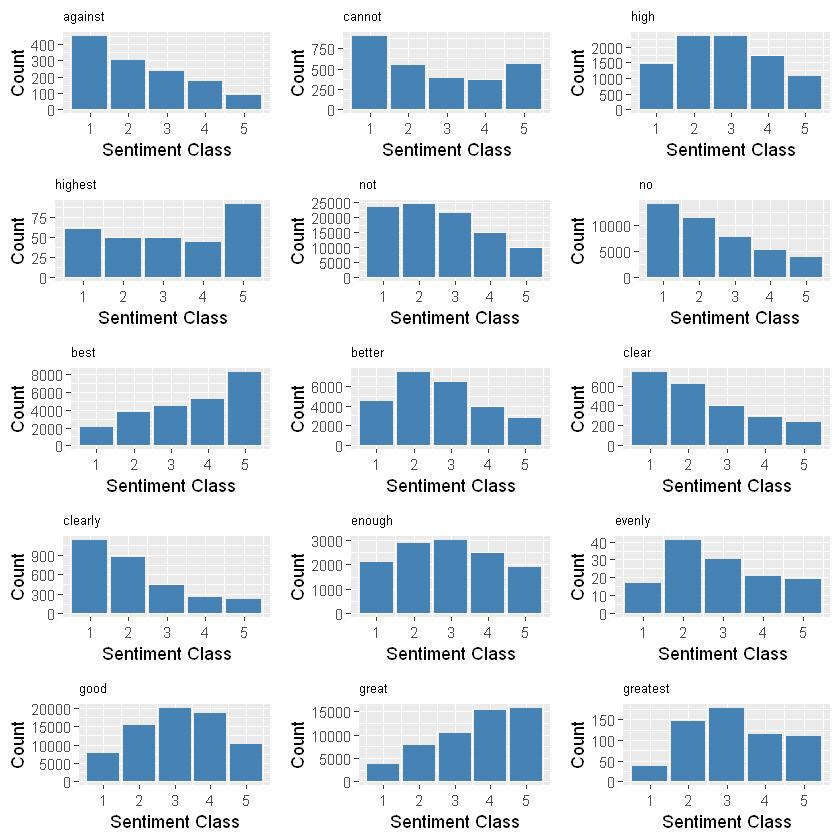

In [26]:
# filter tokens to the above words and plot their sentiment class labels
p1 <- tokens %>% filter(word=='against') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("against") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))
          
p2 <- tokens %>% filter(word=='cannot') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("cannot") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p3 <- tokens %>% filter(word=='high') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("high") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p4 <- tokens %>% filter(word=='highest') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("highest") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p5 <- tokens %>% filter(word=='not') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("not") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p6 <- tokens %>% filter(word=='no') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("no") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p7 <- tokens %>% filter(word=='best') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("best") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p8 <- tokens %>% filter(word=='better') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("better") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p9 <- tokens %>% filter(word=='clear') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("clear") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p10 <- tokens %>% filter(word=='clearly') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("clearly") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p11 <- tokens %>% filter(word=='enough') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("enough") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p12 <- tokens %>% filter(word=='evenly') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("evenly") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p13 <- tokens %>% filter(word=='good') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("good") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))
          
p14 <- tokens %>% filter(word=='great') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("great") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p15 <- tokens %>% filter(word=='greatest') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("greatest") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15, nrow=5, ncol=3)

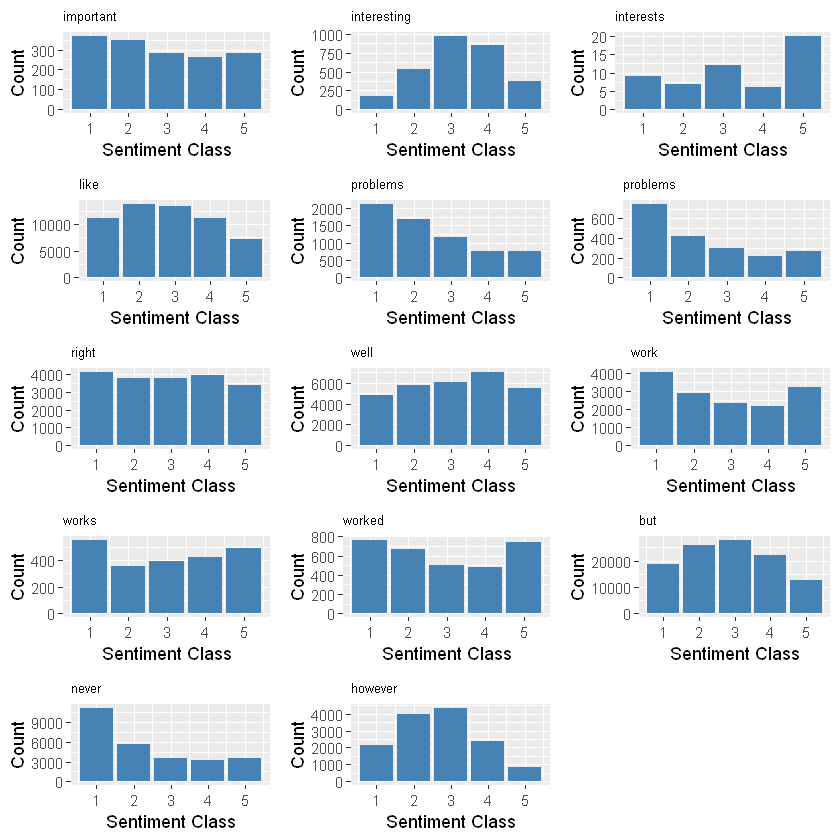

In [27]:
# filter tokens to the above words and plot their sentiment class labels

p1 <- tokens %>% filter(word=='important') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("important") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p2 <- tokens %>% filter(word=='interesting') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("interesting") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p3 <- tokens %>% filter(word=='interests') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("interests") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p4 <- tokens %>% filter(word=='like') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("like") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p5 <- tokens %>% filter(word=='problem') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("problems") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p6 <- tokens %>% filter(word=='problems') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("problems") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p7 <- tokens %>% filter(word=='right') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("right") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p8 <- tokens %>% filter(word=='well') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("well") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p9 <- tokens %>% filter(word=='work') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("work") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p10 <- tokens %>% filter(word=='works') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("works") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p11 <- tokens %>% filter(word=='worked') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("worked") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p12 <- tokens %>% filter(word=='but') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("but") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))


p13 <- tokens %>% filter(word=='never') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("never") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))


p14 <- tokens %>% filter(word=='however') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("however") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))
          

grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, nrow=5, ncol=3)

Looking at the plots, we conclude the following words indeed played a part in the sentiment classes and even though almost all of the words is particular in a sentiment class, we only consider those with a large number of counts.
- not
- no
- best
- better
- enough
- good
- great
- like
- well
- but
- better
- however

Therefore, out of the 429 stopwords found in the `onix` package, we will keep 12 of them.

In [28]:
# store the 12 stopwords in a list
wanted_stopwords <- list("not", "no", "best", "better", "enough", "good", "great", "like", "well", "but", "never", "however")
# remove the wanted_stopwords from onix stopwords
stopwords <- stop_words %>% filter(lexicon == 'onix' & !(word %in% wanted_stopwords))

# remove remaining 420 stopwords from tokens
tokens <- tokens %>% anti_join(stopwords)

rm(bing_sentiments, onix_sentiments, stopwords)

Joining, by = "word"


In [29]:
# Status of corpus
# total number of reviews
tokens %>% summarise(docs_total = n_distinct(doc))
# total number of tokens
tokens %>% summarise(tokens_total = n())
# vocabulary size (number of unique tokens)
tokens %>% summarise(vocab_size = n_distinct(word))
# lexical diversity (average number of tokens per review)
tokens %>% summarise(lex_div = n()/n_distinct(doc))
# min length of review
tokens %>% group_by(doc) %>% summarise(length = sum(n())) %>% summarise(min_length=min(length))
# max length of review
tokens %>% group_by(doc) %>% summarise(length = sum(n())) %>% summarise(max_length=max(length))

docs_total
<int>
199999


tokens_total
<int>
10990246


vocab_size
<int>
123336


lex_div
<dbl>
54.9515


min_length
<dbl>
1


max_length
<dbl>
2787


Corpus status after removal of stopwords:
- Total no. of reviews: 299998
- Total no. of tokens: 16485875
- Total vocabulary size: 151312
- Lexical Diversity: 54.95328
- Smallest Document Size: 1
- Largest Document Size: 5094

## 2.5 Removal of length 1/2 words

In [30]:
# remove length of 1, keep numbers, !, ?
tokens_len1 <- tokens %>% filter(nchar(word)==1)
unique(tokens_len1$word)

[1] "5" "8" "3" "4" "2" "1" "6" "7" "0" "s" "t" "d" " " "9" "u" "f" "m" "e" "w"
[20] "x" "n" "o" "h" "b" "r" "c" "z" "k" "l" "y" "v" "g" "q" "p" "j" "!" "?"

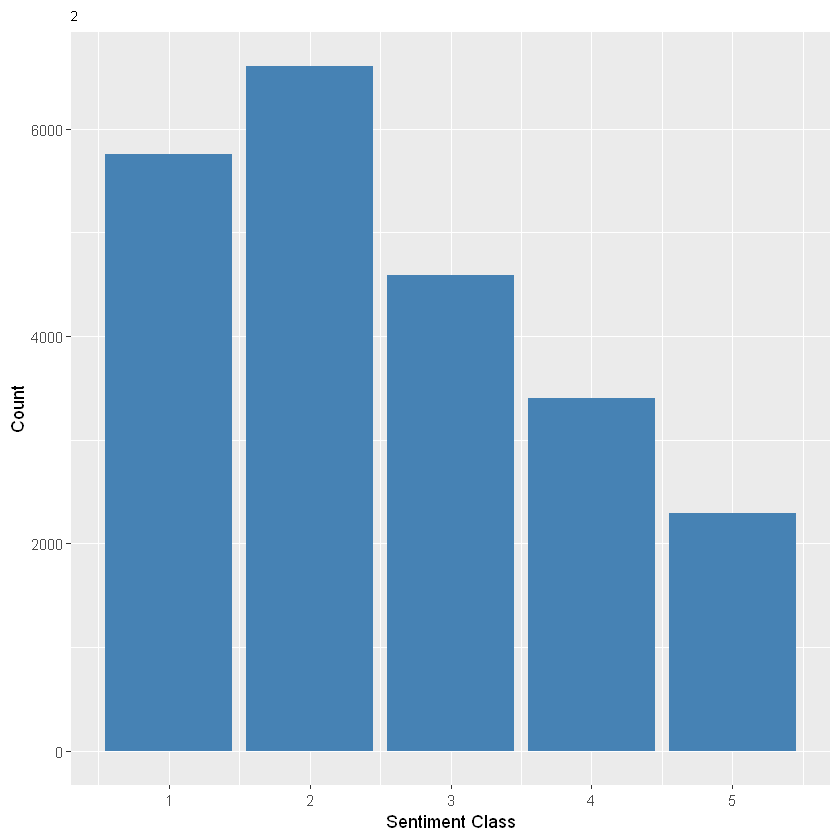

In [34]:
p1 <- tokens %>% filter(word=='2') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("2") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p1

In [31]:
tokens_len2 <- tokens %>% filter(nchar(word)==2)
unique(tokens_len2$word)

[1] "20" "no" "13" "19" "11" "so" "re" "16" "am" "40" "25" "ok" "35" "10" "45"
 [16] "30" "oh" "18" "55" "15" "28" "63" "60" "95" "38" "un" "22" "ms" "80" "ur"
 [31] "la" "bf" "00" "02" "tv" "50" "az" "12" "05" "41" "dr" "np" "24" "lo" "75"
 [46] "ya" "70" "83" "ho" "14" "im" "pm" "aw" "9a" "7p" "5p" "6p" "xs" "dj" "54"
 [61] "id" "cp" "yu" "ny" "ew" "ez" "65" "gt" "ca" "gm" "bs" "mb" "iv" "17" "ti"
 [76] "72" "nv" "3k" "47" "48" "31" "23" "84" "90" "27" "pa" "pt" "ha" "46" "al"
 [91] "cf" "lv" "hi" "st" "06" "dm" "08" "2x" "bc" "yr" "3d" "gh" "er" "uh" "vm"
[106] "de" "le" "49" "co" "rd" "hr" "ja" "29" "ph" "mo" "hd" "nc" "il" "bo" "sh"
[121] "32" "lt" "tm" "os" "97" "tb" "eu" "ne" "je" "3x" "36" "ob" "01" "ce" "en"
[136] "ai" "ma" "du" "ou" "se" "eh" "85" "oo" "qt" "pd" "58" "ac" "74" "81" "ed"
[151] "ae" "sc" "69" "vs" "6s" "rr" "el" "1s" "34" "ps" "yo" "um" "md" "rc" "ni"
[166] "te" "et" "91" "bi" "ly" "04" "ct" "99" "57" "rv" "6v" "07" "03" "fb" "ad"
[181] "61" "fu" "jr" "5k" "8s" "sp" "21" "fo" "gb" "tk" "dy" "nw" "nd" "si" "44"
[196] "mc" "ft" "jb" "39" "sw" "es" "71" "26" "fh" "ss" "rx" "9k" "ws" "tx" "ks"
[211] "th" "ar" "tt" "ii" "ts" "em" "jl" "po" "ro" "wi" "oj" "cc" "1k" "4k" "59"
[226] "nj" "wa" "cd" "hp" "vw" "dd" "7a" "da" "92" "td" "2h" "86" "au" "sa" "fn"
[241] "64" "vp" "tp" "pv" "ol" "ah" "ka" "xt" "ex" "ay" "kk" "oz" "gf" "uv" "aa"
[256] "sz" "  " "ot" "mi" "43" "jj" "cs" "kj" "pp" "m3" "m5" "m6" "ve" "tl" "wk"
[271] "53" "7k" "0f" "sb" "nu" "rm" "sf" "bb" "89" "sy" "ng" "eg" "aj" "67" "ie"
[286] "3 " "1 " "qc" "vi" "56" "sq" "xx" "af" "gy" "ic" "5x" "qs" "42" "mm" "cu"
[301] "rn" "87" "u " "wf" "dt" "33" "ut" "66" "ty" "za" "bp" "98" "ri" "mt" "4s"
[316] "37" "sd" "52" "88" "mg" "96" "bk" "vr" "gp" "uw" "hh" "ru" "93" "fe" "gd"
[331] "2k" "09" "4x" "lb" "vu" "5c" "5s" "i " "ns" "tj" "ck" "78" "ax" "ra" "pu"
[346] "a1" "ap" "fl" "rs" "sr" "gi" "va" "ba" "hs" "dc" "b4" "k9" "pf" "mf" "ev"
[361] "51" "fi" "br" "hw" "ak" "ww" "op" "vt" "ga" "68" "pe" "3g" "76" "fd" "79"
[376] "dq" "jt" "km" "iq" "94" "ll" "pc" "jw" "62" "cb" "x5" "fw" "rt" "hm" "mn"
[391] "lg" "4a" "2a" "su" "uc" "tn" "6x" "xl" "kc" "bq" "hv" "pk" "ag" "x2" "fm"
[406] "77" "t2" "jd" "wo" "fs" "ge" "ue" "lx" "cv" "1h" "cl" "lc" "ff" "ch" "om"
[421] "zk" "dh" "s4" "di" "2d" "6k" "ey" "uk" "82" "t4" "v6" "cn" "b9" "s3" "4g"
[436] "mj" "4c" "bw" "9b" "bu" "jp" "hq" "eb" "x3" "ow" "4d" "1p" "4p" "zu" "fr"
[451] "tr" "kp" "f1" "ds" "jc" "pb" "ab" "a " "9 " "na" "ye" "ki" "qa" "bm" "nr"
[466] "cr" "oy" "qr" "xo" "ig" "tf" "ao" "rw" "cw" "yi" "vh" "ml" "v7" "gc" "ox"
[481] "wl" "g1" "r1" "ci" "rg" "fc" "jo" "dl" "od" "pi" "hu" "kn" "x1" "oq" "8k"
[496] "s9" "r3" "cx" "r7" "ht" "js" "kw" "8p" "5w" "qi" "0z" "2l" "sm" "pr" "mu"
[511] "pj" "cz" "fa" "ea" "qb" "ir" "ky" "2g" "wt" "px" "fx" "gx" "hy" "5g" "vd"
[526] "jk" "sv" "2b" "ta" "tu" "wy" "nt" "dg" "dp" "db" "gs" "hk" "l1" "73" "tz"
[541] "p3" "1m" "h3" "ub" "cj" "f9" "ls" "7x" "og" "c3" "nn" "dv" "nm" "mx" "3p"
[556] "rf" "bt" "3m" "rl" "bh" "2s" "x4" "gr" "x8" "fj" "xq" "fk" "8a" "o2" "6y"
[571] "q5" "ua" "z3" "sg" "dk" "bv" "7s" "b3" "gg" "nx" "s8" "lp" "oi" "9p" "v1"
[586] "hc" "s " "qu" "fp" "wp" "ec" "2p" "zs" "vf" "bz" "m4" "mk" "s6" "b2" "3a"
[601] "8n" "p1" "s7" "tg" "lr" "sl" "d6" "ju" "wm" "lh" "li" "lu" "c0" "ip" "dw"
[616] "ko" "tc" "c2" "hj" "cm" "kb" "vg" "xe" "w2" "bd" "ia" "kr" "qx" "bx" "2m"
[631] "vl" "4 " "8x" "g2" "yp" "h " "hx" "rh" "rb" "t3" "uo" "cy" "q7" "a5" "g8"
[646] "gv" "pg" "d8" "1b" "yd" "jv" "nb" "zi" "yb" "ke" "b " "uf" "t7" "oc" "x6"
[661] "jy" "x7" "q " "2 " "gl" "ee" "3s" "mv" "wu" "e1" "qg" "kd" "sk" "wg" "zj"
[676] "fv" "l5" "rk" "gw" "zz" "3c" "1c" "pw" "xa" "sj" "ik" "mw" "bl" "e2" "av"
[691] "mh" "xu" "gn" "kg" "io" "xd" "r9" "hf" "3o" "1g" "dz" "ui" "k " "5 " "u2"
[706] "ku" "i7" "ld" "gq" "df" "c " "1x" "wc" " o" "nh" "a4" "vj" "tw" "xy" "t "
[721] "wd" "mp" "3e" "6a" "ze" "c5" "lm" "3h" "6m" "bj" "qq" "bg" "ys" "k1" "ib"
[736] "hb" "t1" "4l" "kt" "1l" "a

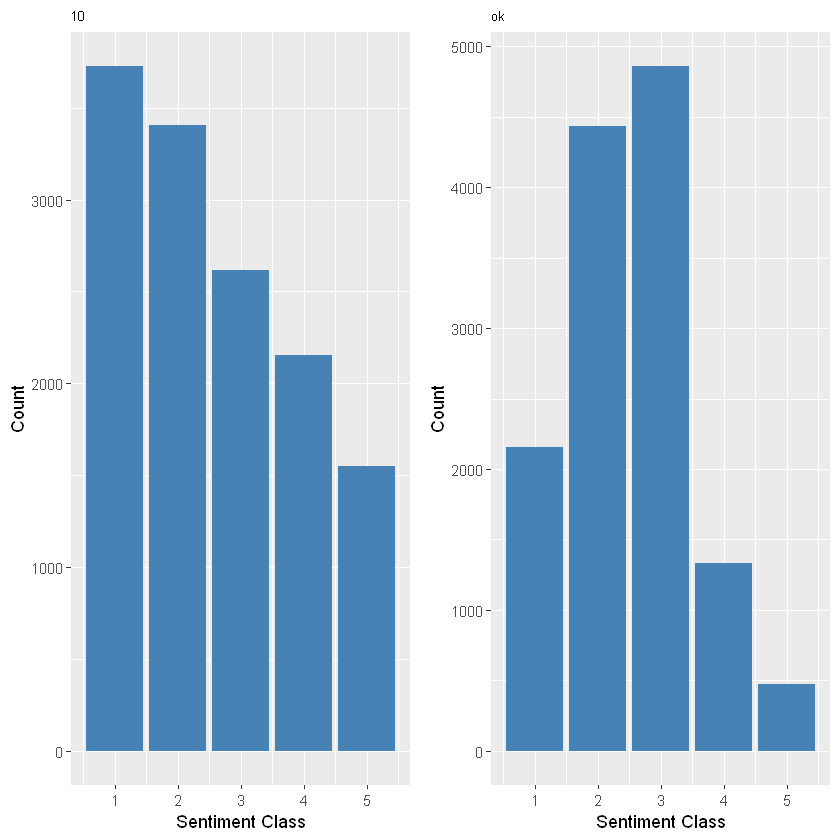

In [36]:
p1 <- tokens %>% filter(word=='10') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("10") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p2 <- tokens %>% filter(word=='ok') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("ok") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

grid.arrange(p1, p2, ncol = 2, nrow = 1)

In [37]:
# remove length of 1, keep numbers, !, ?
tokens_len1 <- tokens %>% filter(nchar(word)==1)
removeonelen <- function(x) gsub("[^0-9!?]", " ", x)
tokens_len1$word <- as.character(unlist(lapply(tokens_len1$word, removeonelen)))
unwanted_len1 <- tokens %>% filter(nchar(word)==1) %>% anti_join(tokens_len1, by='word')
tokens <- tokens %>% anti_join(unwanted_len1)

rm(tokens_len1, unwanted_len1, removeonelen)

# remove length of 2, keep "no", "ok", "10"
tokens_len2 <- tokens %>% filter(nchar(word)==2)
wanted_len2 <- list("no", "ok", "10")
tokens_len2 <- tokens_len2 %>% filter(!(word %in% wanted_len2))
tokens <- tokens %>% anti_join(tokens_len2)

rm(tokens_len2, wanted_len2)

Joining, by = c("doc", "label", "word")
Joining, by = c("doc", "label", "word")


In [38]:
# Status of corpus
# total number of reviews
tokens %>% summarise(docs_total = n_distinct(doc))
# total number of tokens
tokens %>% summarise(tokens_total = n())
# vocabulary size (number of unique tokens)
tokens %>% summarise(vocab_size = n_distinct(word))
# lexical diversity (average number of tokens per review)
tokens %>% summarise(lex_div = n()/n_distinct(doc))
# min length of review
tokens %>% group_by(doc) %>% summarise(length = sum(n())) %>% summarise(min_length=min(length))
# max length of review
tokens %>% group_by(doc) %>% summarise(length = sum(n())) %>% summarise(max_length=max(length))

docs_total
<int>
199997


tokens_total
<int>
10648051


vocab_size
<int>
122420


lex_div
<dbl>
53.24105


min_length
<dbl>
1


max_length
<dbl>
2787


## 2.6 Removal of most/least frequent words

We will set the threshold to remove those unigrams that appeared in more than 99% of the total documents or less than 1% of the total documents based on the document frequency.

In [39]:
# get document frequency
doc_freq <- tokens %>% 
  group_by(word) %>% 
  summarise(docs_total = n_distinct(doc)) %>%
  arrange(desc(docs_total))

In [43]:
head(doc_freq, 10)

word,docs_total
<chr>,<int>
but,107400
not,94046
!,83774
food,73129
good,71978
service,61219
like,56712
time,53222
great,52635


In [42]:
tail(doc_freq,10)

word,docs_total
<chr>,<int>
zz26z26,1
zza,1
zzapreti,1
zzuvy5ynzbud27blpa,1
zzzzzzz,1
zzzzzzzs,1
zzzzzzzzz,1
zzzzzzzzzz,1
zzzzzzzzzzzz,1


In [47]:
# filter to those tokens that appear more than 99% and less than 1% of total training size, and not containing wanted_stopwords
unwanted_tokens <- doc_freq %>% filter((docs_total >= 0.99*nrow(train_data)| docs_total <= 0.003*nrow(train_data)) & !(word %in% wanted_stopwords))
# get the new tokens by performing anti_join with the unwanted tokens
tokens <- tokens %>% anti_join(unwanted_tokens)

rm(doc_freq, unwanted_tokens)

Joining, by = "word"


In [50]:
# Status of corpus
# total number of reviews
tokens %>% summarise(docs_total = n_distinct(doc))
# total number of tokens
tokens %>% summarise(tokens_total = n())
# vocabulary size (number of unique tokens)
tokens %>% summarise(vocab_size = n_distinct(word))
# lexical diversity (average number of tokens per review)
tokens %>% summarise(lex_div = n()/n_distinct(doc))
# min length of review
tokens %>% group_by(doc) %>% summarise(length = sum(n())) %>% summarise(min_length=min(length))
# max length of review
tokens %>% group_by(doc) %>% summarise(length = sum(n())) %>% summarise(max_length=max(length))

docs_total
<int>
199978


tokens_total
<int>
8423732


vocab_size
<int>
2188


lex_div
<dbl>
42.12329


min_length
<dbl>
1


max_length
<dbl>
494


## 3.1 Feature Generation - Bigrams
We have currently only considered unigrams and we will explore bigrams which are made of 2 consecutive words in a document. Similarly to the way we generate unigrams previously, we can use `unnest_tokens` in `tidytext` package to generate bigrams.

In [51]:
# using unnest_tokens in tidytext library with n=2 to generate bigrams
bigrams <- train_data %>% unnest_tokens(bigram, text, token = "ngrams", n = 2)

In [52]:
# total number of bigrams
bigrams %>% summarise(bigrams_total = n())
# vocabulary size (number of unique bigrams)
bigrams %>% summarise(vocab_size = n_distinct(bigram))

bigrams_total
<int>
24528130


vocab_size
<int>
2826395


Initial bigrams corpus status:
- Total no. of bigrams: 36786574
- Total vocabulary size: 3688320

We first look at the document frequency of the bigrams.

In [53]:
# get document frequency for bigrams
bigrams_freq <- bigrams %>% 
  group_by(bigram) %>% 
  summarise(docs_total = n_distinct(doc)) %>% arrange(desc(docs_total))

# look at top 10 bigrams
head(bigrams_freq, 10)

bigram,docs_total
<chr>,<int>
of the,52678
it was,52065
and the,50973
in the,48861
this place,39987
on the,38925
i was,38599
and i,36787
for the,36086


Looking at the top 10 bigrams based on document frequeny, they mostly are made up of two consecutive stopwords. Hence, we should remove these bigrams.

However, as what we have noted in unigrams, there might be some bigrams which consists of both stopwords being influential in determining the sentiment rating for the review especially if these words suggest possible negative or positive sentiments. There is currently no in-built packages which can analyse the sentiments for bigrams, so we will proceed with context-interpretation of possible significant bigrams using combinations of those unigrams' stopwords that we have identified earlier.

We can consider the 12 unigrams stopwords that we have identified earlier and explore the effects of bigrams containing these 9 words (i.e. <i>not, no, best, better, enough, good, great, like, well, but, never, however</i>) and see if the sentiment classes are indicative. Bigrams that include prefixes stopwords like <i>'not'</i>, <i>'very'</i>, <i>'will'</i>, <i>but</i> might indicate a stronger negative or positive sentiment when paired with a suffix that is indicative in terms of sentiments like <i>good</i>, <i>great</i>, <i>best</i>. 

The following bigrams are those we considered:
- not good
- not great
- will not
- was not
- do not
- very good
- very long
- will never
- the best
- a great
- was good
- a must
- but the

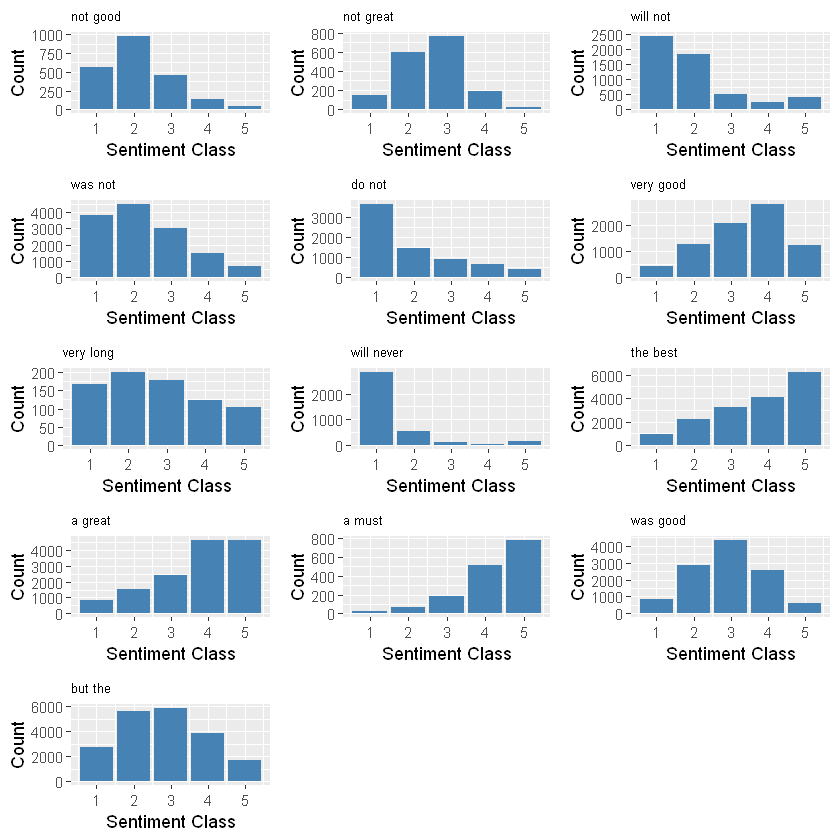

In [55]:
# filter tokens to the above words and plot their sentiment class labels
p1 <- bigrams %>% filter(bigram=='not good') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("not good") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p2 <- bigrams %>% filter(bigram=='not great') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("not great") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p3 <- bigrams %>% filter(bigram=='will not') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("will not") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p4 <- bigrams %>% filter(bigram=='was not') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("was not") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p5 <- bigrams %>% filter(bigram=='do not') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("do not") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p6 <- bigrams %>% filter(bigram=='very good') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("very good") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p7 <- bigrams %>% filter(bigram=='very long') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("very long") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p8 <- bigrams %>% filter(bigram=='will never') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("will never") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p9 <- bigrams %>% filter(bigram=='the best') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("the best") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p10 <- bigrams %>% filter(bigram=='a great') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("a great") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p11 <- bigrams %>% filter(bigram=='a must') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("a must") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p12 <- bigrams %>% filter(bigram=='was good') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("was good") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))

p13 <- bigrams %>% filter(bigram=='but the') %>%
    group_by(label) %>% 
    summarise(count = n_distinct(doc)) %>%
    ggplot() + 
    geom_bar(aes(x = label, y = count), stat = "identity", fill='steelblue')  +
    ggtitle("but the") + labs(x = 'Sentiment Class', y = "Count") +
    theme(plot.title = element_text(size=8))


grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, nrow=5, ncol=3)

Looking at the plots, the 13 bigrams other than <i>very long</i> seem indicative towards a particular sentiment class and the frequencies are relatively high. Hence, we will keep the remaining 12 bigrams in our bigrams vocabulary.

- not good
- not great
- will not
- was not
- do not
- very good
- will never
- the best
- a great
- was good
- a must
- but the

In [56]:
wanted_bigrams_list <- list("not good", "not great", "will not", "was not", "do not", "very good", "will never",
                            "the best", "a great", "was good", "a must", "but the")

# get these bigrams records
wanted_bigrams <- bigrams %>% filter(bigram %in% wanted_bigrams_list)

# filter stopwords to onix lexicon
stopwords <- stop_words %>% filter(lexicon == 'onix')
# separate the bigrams into individual words
bigrams_separated <- bigrams %>% separate(bigram, c("word1", "word2"), sep = " ")

# remove special char
removespecialchar <- function(x) gsub("[^a-zA-Z0-9'!?]", " ", x)
bigrams_separated$word1 <- as.character(unlist(lapply(bigrams_separated$word1, removespecialchar)))
bigrams_separated$word2 <- as.character(unlist(lapply(bigrams_separated$word2, removespecialchar)))

# remove all bigrams with both stopwords
bigrams <- bigrams_separated %>% filter(!word1 %in% stopwords$word) %>%
            filter(!word2 %in% stopwords$word)

rm(bigrams_separated, stopwords)

# remove all bigrams with both word that is of length 1
bigrams <- bigrams %>% filter(nchar(word1)>1) %>%
            filter(nchar(word2)>1)

# join back the bigrams
bigrams <- bigrams %>% unite(bigram, word1, word2, sep=" ")

# add back the wanted_bigrams to bigrams list
bigrams <- rbind(bigrams, wanted_bigrams)

rm(wanted_bigrams)

# get top 100 bigrams based on document frequency
wanted_bigrams <- bigrams %>% 
  group_by(bigram) %>% 
  summarise(docs_total = n_distinct(doc)) %>% 
  arrange(desc(docs_total)) %>%
  top_n(100)

# get the new bigrams by performing semi_join with the wanted bigrams
bigrams <- bigrams %>% semi_join(wanted_bigrams)

rm(wanted_bigrams)

Selecting by docs_total
Joining, by = "bigram"


In [57]:
# total number of bigrams
bigrams %>% summarise(tokens_total = n())
# vocabulary size (number of unique bigrams)
bigrams %>% summarise(vocab_size = n_distinct(bigram))

tokens_total
<int>
252670


vocab_size
<int>
100


In [73]:
## get feature set 1

# change colnames of bigrams dataframe for ease of merging
colnames(bigrams) <- c('doc', 'label', 'word')
# get final training tokens set 1 by binding both unigrams and bigrams
feature_set_1 <- rbind(tokens, bigrams)

In [61]:
# Status of corpus for featureset1
# total number of reviews
feature_set_1 %>% summarise(docs_total = n_distinct(doc))
# total number of tokens
feature_set_1 %>% summarise(tokens_total = n())
# vocabulary size (number of unique tokens)
feature_set_1 %>% summarise(vocab_size = n_distinct(word))
# lexical diversity (average number of tokens per review)
feature_set_1 %>% summarise(lex_div = n()/n_distinct(doc))

docs_total
<int>
199978


tokens_total
<int>
8676402


vocab_size
<int>
2288


lex_div
<dbl>
43.38678


Therefore, our first feature set will consists of both unigrams and bigrams.

Number of unique unigram tokens: <b>2188</b> <br>
Number of unique bigram tokens: <b>100</b><br>
Total number of unique tokens in feature set 1: <b>2288</b><br>

## 3.2 Feature Generation - Trigrams
The second method is trigrams generation.

In [66]:
# using unnest_tokens in tidytext library with n=3 to generate trigrams
trigrams <- train_data %>% unnest_tokens(trigram, text, token = "ngrams", n = 3)

# filter stopwords to onix lexicon
stopwords <- stop_words %>% filter(lexicon == 'onix')
# separate the trigrams into individual words
trigrams_separated <- trigrams %>% separate(trigram, c("word1", "word2", "word3"), sep = " ")

# remove all trigrams with three stopwords
trigrams <- trigrams_separated %>% filter(!word1 %in% stopwords$word) %>%
            filter(!word2 %in% stopwords$word) %>% filter(!word3 %in% stopwords$word)

rm(trigrams_separated, stopwords)

# remove all trigrams with all 3 word that is of length 1
trigrams <- trigrams %>% filter(nchar(word1)>1) %>%
            filter(nchar(word2)>1) %>%
            filter(nchar(word3)>1)

# join back the trigrams
trigrams <- trigrams %>% unite(trigram, word1, word2, word3, sep=" ")

In [67]:
# get the top 50 trigrams
wanted_trigrams <- trigrams %>% 
  group_by(trigram) %>% 
  summarise(docs_total = n_distinct(doc)) %>% 
  arrange(desc(docs_total)) %>%
  top_n(50)

head(wanted_trigrams, 10)

Selecting by docs_total


trigram,docs_total
<chr>,<int>
sweet potato fries,525
poor customer service,500
horrible customer service,465
worst customer service,465
terrible customer service,350
bad customer service,283
excellent customer service,276
customer service skills,275
love love love,275


In [68]:
# get the new trigrams by performing semi_join with the wanted trigrams
trigrams <- trigrams %>% semi_join(wanted_trigrams)

rm(wanted_trigrams)

Joining, by = "trigram"


In [69]:
## get feature set 2

# change colnames of bigrams dataframe for ease of merging
colnames(bigrams) <- c('doc', 'label', 'word')
# change colnames of trigrams dataframe for ease of merging
colnames(trigrams) <- c('doc', 'label', 'word')
# get final training tokens set 1 by binding both unigrams and bigrams
feature_set_2 <- rbind(tokens, bigrams, trigrams)

In [70]:
# Status of corpus for featureset2
# total number of reviews
feature_set_2 %>% summarise(docs_total = n_distinct(doc))
# total number of tokens
feature_set_2 %>% summarise(tokens_total = n())
# vocabulary size (number of unique tokens)
feature_set_2 %>% summarise(vocab_size = n_distinct(word))
# lexical diversity (average number of tokens per review)
feature_set_2 %>% summarise(lex_div = n()/n_distinct(doc))

docs_total
<int>
199978


tokens_total
<int>
8686779


vocab_size
<int>
2338


lex_div
<dbl>
43.43867


Therefore, our second feature set will consists of unigrams, bigrams and trigrams.

Number of unique unigram tokens: <b>2188</b> <br>
Number of unique bigram tokens: <b>100</b><br>
Number of unique trigram tokens: <b>50</b><br>
Total number of unique tokens in feature set 1: <b>2338</b><br>

## 4. Model Development

We first prepare the training data into document term matrix for ease of model training by writing a function which will process our feature sets and convert it into a document termed matrix.

Numbers have been appended with a `X` in front and words with apostrophe had their apostrophe replaced with a `.` <br>
`!` and `?` have been replaced with `X.` and `X..1` respectively.

In [8]:
traindata_processor <- function(training_tokens){

    # convert to document term matrix using tm library
    pre_tdm <- training_tokens %>% group_by(doc,word) %>% summarise(count = n())
    dtm <- pre_tdm %>% cast_tdm(doc,word,count)
    rm(pre_tdm)

    # convert it into a matrix
    doc_matrix <- as.matrix(dtm)
    rm(dtm)

    # add in the sentiment class label to this matrix for each document
    overall_doc_matrix <- merge(doc_matrix, as.matrix(train_data[,c(1,3)]), by.x="row.names", by.y='doc')
    rm(doc_matrix)
    # remove 1st column which is the document id
    overall_doc_matrix <- overall_doc_matrix[,-1]
    # change target variable to factor
    overall_doc_matrix$label <- factor(overall_doc_matrix$label)

    # store initial column names for ease of reference
    actual_colnames <- colnames(overall_doc_matrix)
    # use check.names to convert column names into readable format
    train_tokens <- data.frame(overall_doc_matrix, check.names=TRUE)

    return (train_tokens)
}

In [12]:
feature_set_1 <- read.csv("./featureset1final.csv", header=TRUE, sep=" ")

In [ ]:
# get training tokens in doc matrix form after generating feature set 1 or set 2 or set 3
train_tokens <- traindata_processor(feature_set_1)
rm(feature_set_1)

In [28]:
memory.limit(size=12000)

[1] 12000

In [ ]:
write.csv(train_tokens, file = "train_tokens2k.csv")

In [ ]:
dim(train_tokens)

# ------------------------------------------------------------------------------------------------------- #

# ------------------------------------------------------------------------------------------------------- #

# Overall Preprocessing Code

In [9]:
## Data Loading

# load in training data
train_data <- read.csv(file="./train_data.csv", header=TRUE, sep=",", stringsAsFactors = FALSE)
# load in training label
train_label <- read.csv(file="./train_label.csv", header=TRUE, sep=",")
# we first merge both training data and it's label together
train_data_merge <- merge(x = train_data, y = train_label, by = "trn_id", all = TRUE, sort = FALSE)

# remove duplicated data
train_data_merge <- train_data_merge[!duplicated(train_data_merge[,c('text','label')]),]
# remove duplicated text with different labels
train_data_merge <- train_data_merge[!duplicated(train_data_merge[,'text']),]

# convert table to tibble format
train_data_merge <- tibble(doc=1:nrow(train_data_merge),text=train_data_merge$text,label=train_data_merge$label)

# set seed to ensure make results reproducible
set.seed(123)
# filter to the classes
class1 <- train_data_merge[train_data_merge$label==1,]
class2 <- train_data_merge[train_data_merge$label==2,]
class3 <- train_data_merge[train_data_merge$label==3,]
class4 <- train_data_merge[train_data_merge$label==4,]
class5 <- train_data_merge[train_data_merge$label==5,]

# sample 200000 records from each classes as training sample
sample1 <- class1[sample(nrow(class1), 40000),]
sample2 <- class2[sample(nrow(class2), 40000),]
sample3 <- class3[sample(nrow(class3), 40000),]
sample4 <- class4[sample(nrow(class4), 40000),]
sample5 <- class5[sample(nrow(class5), 40000),]

# combine all sample to form train_data
train_data <- rbind(sample1, sample2, sample3, sample4, sample5)

In [10]:
## Text Preprocessing

# using unnest_tokens in tidytext library
tokens <- train_data %>% unnest_tokens(word, text, strip_punct = FALSE)

# unnest tokens again to remove all punctuations
temp_tokens <- train_data %>% unnest_tokens(word, text, strip_punct = TRUE)
# add in the tokens with '!' and '?'
tokens <- temp_tokens %>% bind_rows(tokens %>% filter(word=='!' | word=='?'))

rm(temp_tokens)

# remove special char
removespecialchar <- function(x) gsub("[^a-zA-Z0-9'!?]", " ", x)
tokens$word <- as.character(unlist(lapply(tokens$word, removespecialchar)))

# store the 12 stopwords in a list
wanted_stopwords <- list("not", "no", "best", "better", "enough", "good", "great", "like", "well", "but", "never", "however")
# remove the wanted_stopwords from onix stopwords
stopwords <- stop_words %>% filter(lexicon == 'onix' & !(word %in% wanted_stopwords))

# remove remaining 420 stopwords from tokens
tokens <- tokens %>% anti_join(stopwords)

rm(stopwords)

# remove length of 1, keep numbers, !, ?
tokens_len1 <- tokens %>% filter(nchar(word)==1)
removeonelen <- function(x) gsub("[^0-9!?]", " ", x)
tokens_len1$word <- as.character(unlist(lapply(tokens_len1$word, removeonelen)))
unwanted_len1 <- tokens %>% filter(nchar(word)==1) %>% anti_join(tokens_len1, by='word')
tokens <- tokens %>% anti_join(unwanted_len1)

rm(tokens_len1, unwanted_len1, removeonelen)

# remove length of 2, keep "no", "ok", "10"
tokens_len2 <- tokens %>% filter(nchar(word)==2)
wanted_len2 <- list("no", "ok", "10")
tokens_len2 <- tokens_len2 %>% filter(!(word %in% wanted_len2))
tokens <- tokens %>% anti_join(tokens_len2)

rm(tokens_len2, wanted_len2)

# remove white space
tokens <- tokens %>% filter(!((word==" ") | (word=="")))

doc_freq <- tokens %>% 
  group_by(word) %>% 
  summarise(docs_total = n_distinct(doc)) %>%
  arrange(desc(docs_total))

# filter to those tokens that appear more than 99% and less than 0.3% of total training size, and not containing wanted_stopwords
unwanted_tokens <- doc_freq %>% filter((docs_total >= 0.99*nrow(train_data)| docs_total <= 0.003*nrow(train_data)) & !(word %in% wanted_stopwords))
# get the new tokens by performing anti_join with the unwanted tokens
tokens <- tokens %>% anti_join(unwanted_tokens)

rm(doc_freq, wanted_stopwords, unwanted_tokens)

Joining, by = "word"
Joining, by = c("doc", "label", "word")
Joining, by = c("doc", "label", "word")
Joining, by = "word"


In [11]:
# Status of corpus
# total number of reviews
tokens %>% summarise(docs_total = n_distinct(doc))
# total number of tokens
tokens %>% summarise(tokens_total = n())
# vocabulary size (number of unique tokens)
tokens %>% summarise(vocab_size = n_distinct(word))
# lexical diversity (average number of tokens per review)
tokens %>% summarise(lex_div = n()/n_distinct(doc))
# min length of review
tokens %>% group_by(doc) %>% summarise(length = sum(n())) %>% summarise(min_length=min(length))
# max length of review
tokens %>% group_by(doc) %>% summarise(length = sum(n())) %>% summarise(max_length=max(length))

docs_total
<int>
199978


tokens_total
<int>
8423732


vocab_size
<int>
2188


lex_div
<dbl>
42.12329


min_length
<dbl>
1


max_length
<dbl>
494


In [ ]:
## Feature Selection - Set 1 (Unigrams + Bigrams)

# using unnest_tokens in tidytext library with n=2 to generate bigrams
bigrams <- train_data %>% unnest_tokens(bigram, text, token = "ngrams", n = 2)

# store the above bigrams in a list
wanted_bigrams_list <- list("not good", "not great", "will not", "was not", "do not", "very good", "will never",
                            "the best", "a great", "was good", "a must", "but the")

# get these bigrams records
wanted_bigrams <- bigrams %>% filter(bigram %in% wanted_bigrams_list)

# filter stopwords to onix lexicon
stopwords <- stop_words %>% filter(lexicon == 'onix')
# separate the bigrams into individual words
bigrams_separated <- bigrams %>% separate(bigram, c("word1", "word2"), sep = " ")

# remove special char
removespecialchar <- function(x) gsub("[^a-zA-Z0-9'!?]", " ", x)
bigrams_separated$word1 <- as.character(unlist(lapply(bigrams_separated$word1, removespecialchar)))
bigrams_separated$word2 <- as.character(unlist(lapply(bigrams_separated$word2, removespecialchar)))

# remove all bigrams with both stopwords
bigrams <- bigrams_separated %>% filter(!word1 %in% stopwords$word) %>%
            filter(!word2 %in% stopwords$word)

rm(bigrams_separated, stopwords)

# remove all bigrams with both word that is of length 1
bigrams <- bigrams %>% filter(nchar(word1)>1) %>%
            filter(nchar(word2)>1)

# join back the bigrams
bigrams <- bigrams %>% unite(bigram, word1, word2, sep=" ")

# add back the wanted_bigrams to bigrams list
bigrams <- rbind(bigrams, wanted_bigrams)

rm(wanted_bigrams)

# get bigrams document frequency
bigrams_freq <- bigrams %>% 
  group_by(bigram) %>% 
  summarise(docs_total = n_distinct(doc)) %>%
  arrange(desc(docs_total))

# filter away those bigrams that appear less than 0.5% of total training datasize, and keep those wanted bigrams as well
unwanted_bigrams <- bigrams_freq %>% filter((docs_total <= 0.005*nrow(train_data)) & !(bigram %in% wanted_bigrams_list))
# get the new bigrams by performing anti_join with the unwanted bigrams
bigrams <- bigrams %>% anti_join(unwanted_bigrams)

rm(wanted_bigrams_list, unwanted_bigrams)

In [20]:
# total number of bigrams
bigrams %>% summarise(tokens_total = n())
# vocabulary size (number of unique bigrams)
bigrams %>% summarise(vocab_size = n_distinct(bigram))

tokens_total
<int>
208033


vocab_size
<int>
53


In [ ]:
# change colnames of bigrams dataframe for ease of merging
colnames(bigrams) <- c('doc', 'label', 'word')
# get final training tokens set 1 by binding both unigrams and bigrams
feature_set_1 <- rbind(tokens, bigrams)

In [ ]:
# Status of corpus after feature selection 1
# total number of reviews
feature_set_1 %>% summarise(docs_total = n_distinct(doc))
# total number of tokens
feature_set_1 %>% summarise(tokens_total = n())
# vocabulary size (number of unique tokens)
feature_set_1 %>% summarise(vocab_size = n_distinct(word))
# lexical diversity (average number of tokens per review)
feature_set_1 %>% summarise(lex_div = n()/n_distinct(doc))
# min length of review
feature_set_1 %>% group_by(doc) %>% summarise(length = sum(n())) %>% summarise(min_length=min(length))
# max length of review
feature_set_1 %>% group_by(doc) %>% summarise(length = sum(n())) %>% summarise(max_length=max(length))

In [ ]:
## Feature Selection - Set 2 (Unigrams + Bigrams + Trigrams)

# using unnest_tokens in tidytext library with n=3 to generate trigrams
trigrams <- train_data %>% unnest_tokens(trigram, text, token = "ngrams", n = 3)

# filter stopwords to onix lexicon
stopwords <- stop_words %>% filter(lexicon == 'onix')
# separate the trigrams into individual words
trigrams_separated <- trigrams %>% separate(trigram, c("word1", "word2", "word3"), sep = " ")

# remove all trigrams with three stopwords
trigrams <- trigrams_separated %>% filter(!word1 %in% stopwords$word) %>%
            filter(!word2 %in% stopwords$word) %>% filter(!word3 %in% stopwords$word)

rm(trigrams_separated, stopwords)

# remove all trigrams with all 3 word that is of length 1
trigrams <- trigrams %>% filter(nchar(word1)>1) %>%
            filter(nchar(word2)>1) %>%
            filter(nchar(word3)>1)

# join back the trigrams
trigrams <- trigrams %>% unite(trigram, word1, word2, word3, sep=" ")

# get the top 100 trigrams
wanted_trigrams <- trigrams %>% 
  group_by(trigram) %>% 
  summarise(docs_total = n_distinct(doc)) %>% 
  arrange(desc(docs_total)) %>%
  top_n(100)

# get the new trigrams by performing semi_join with the wanted trigrams
trigrams <- trigrams %>% semi_join(wanted_trigrams)

rm(wanted_trigrams)

In [ ]:
## get feature set 2

# change colnames of bigrams dataframe for ease of merging
colnames(bigrams) <- c('doc', 'label', 'word')
# change colnames of trigrams dataframe for ease of merging
colnames(trigrams) <- c('doc', 'label', 'word')
# get final training tokens set 2 by binding unigrams, bigrams and trigrams
feature_set_2 <- rbind(tokens, bigrams, trigrams)

# ------------------------------------------------------------------------------------------------------- #

# 5. Real Testing Data
## 5.1 Testing Data Processor

In [42]:
# load in testing data
real_test_data <- read.csv(file="./test_data.csv", header=TRUE, sep="," ,stringsAsFactors = FALSE)
# store test_id in a variable for ease of output
testing_id <- real_test_data$test_id
# convert to tibble format
real_test_data <- tibble('doc_id'=1:nrow(real_test_data), 'text'=real_test_data$text)

# function to generate testing dataset in a matrix based on the training tokens used in the model
testdata_processor <- function(training_tokens){
    # using unnest_tokens in tidytext library to get all tokens in testing dataset
    all_test_unigrams <- real_test_data %>% unnest_tokens(word, text, strip_punct = FALSE)
    # using unnest_tokens in tidytext library to get all bigrams in testing dataset
    all_test_bigrams <- real_test_data %>% unnest_tokens(word, text, token = "ngrams", n = 2)
    # combine both unigrams and bigrams
    all_test_tokens <- rbind(all_test_unigrams, all_test_bigrams)
    
    # filter all_test_tokens to just those used in the training dataset
    test_tokens <- all_test_tokens  %>% semi_join(training_tokens)

    # get the doc_id of those testing dataset that contains 0 training tokens
    empty_docs <- unique(anti_join(all_test_tokens, test_tokens, by='doc_id')$doc_id)

    # convert to document term matrix using tm library
    pre_tdm_test <- test_tokens %>% group_by(doc_id,word) %>% summarise(count = n())
    dtm_test <- pre_tdm_test %>% cast_tdm(doc_id,word,count)

    # convert it into a matrix
    doc_matrix_test <- as.matrix(dtm_test)

    # insert rows of all zeroes into doc_matrix_test for those documents with empty tokens
    for (each in empty_docs){
        empty_matrix = matrix(0, ncol = ncol(doc_matrix_test))
        temp_matrix_1 = doc_matrix_test[1:each-1,]
        temp_matrix_2 = doc_matrix_test[each:nrow(doc_matrix_test),]
        doc_matrix_test = rbind(temp_matrix_1, empty_matrix, temp_matrix_2)
    }
    
    # use check.names to convert column names into readable format and store result as dataframe
    doc_matrix_test <- data.frame(doc_matrix_test, check.names=TRUE)
    
    return (doc_matrix_test)
}

In [43]:
testdata <- testdata_processor(feature_set_1)

Joining, by = "word"


In [44]:
dim(testdata)

[1] 50000  2564

In [45]:
write.csv(testdata, file = "test_tokens25k.csv", row.names=FALSE, quote=FALSE)